In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

### 2 Log-sum-exp and soft(arg)max

(b)

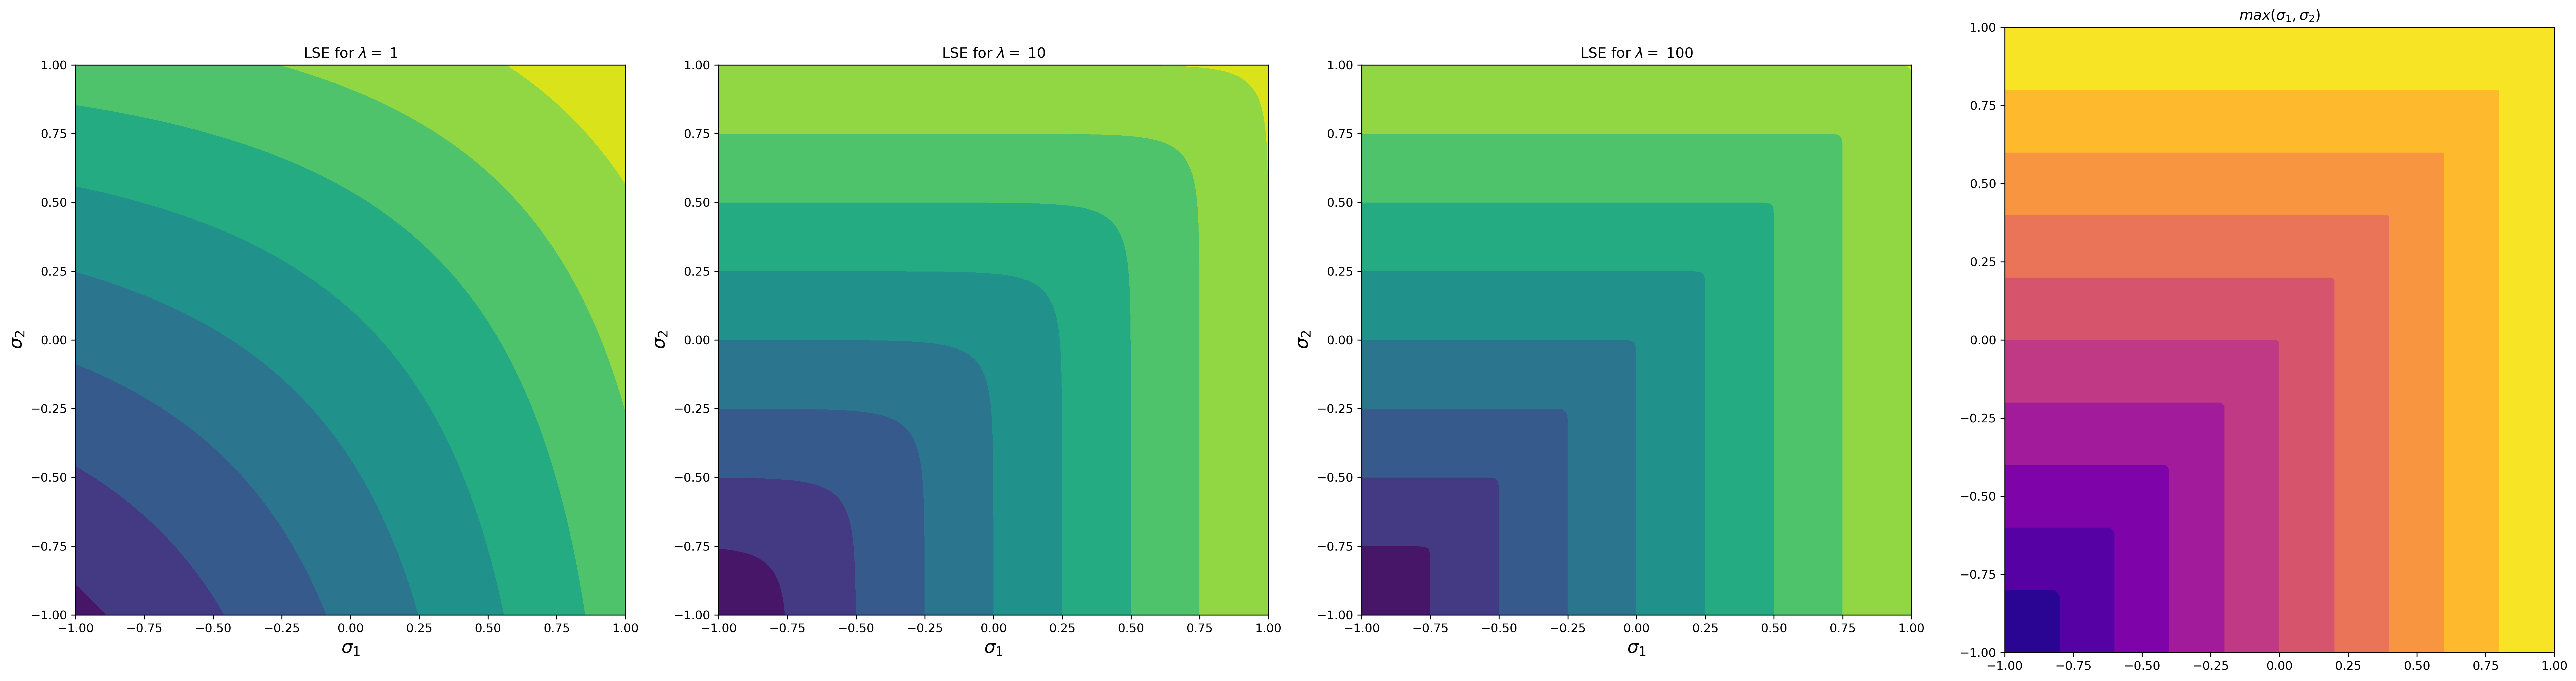

In [2]:
def logsumexp(x, lam=1):
    # TODO: implement the logsumexp
    lse = (1/lam)*np.log((np.exp(lam*x[0])+np.exp(lam*x[1])))
    return lse

# TODO: set up a grid of points in [-1, 1] x [-1, 1]
xlist = np.linspace(-1, 1.0, 100)  ##creating xlists and ylists from -1 to 1 and taking 100 points in between
ylist = np.linspace(-1, 1.0, 100)   ##creating ylists as above
sigmas = np.meshgrid(xlist, ylist)  ##creating meshgrid

# TODO: I recommend you set up a function to set up an Axes object with the correct x, y labels, 
#       equal aspect and maybe x and y ticks.
fig,axs = plt.subplots(ncols = 4,figsize = (30,8),dpi=300)

def set_up_axes(ax):
    ax.set_xlabel(r'$\sigma_1$',size = 15)
    ax.set_ylabel(r'$\sigma_2$',size = 15)
    ax.set_aspect('equal')

lamb_array = [1,10,100]

for i in range (len(lamb_array)):
    lamb = lamb_array[i]

    lse = logsumexp(sigmas,lam = lamb)
    
    axs[i].contourf(*sigmas,lse,8)
    axs[i].set_title(r'LSE for $\lambda = $ ' + str(lamb))
    set_up_axes(axs[i])

# # TODO: calculate and plot the functions as specified in the task
max_sls2 = np.max([sigmas[0],sigmas[1]],axis = 0)
axs[3].contourf(*sigmas,max_sls2,10, cmap = 'plasma')
axs[3].set_title(r'$max(\sigma_1,\sigma_2)$')

fig.tight_layout()

(c)

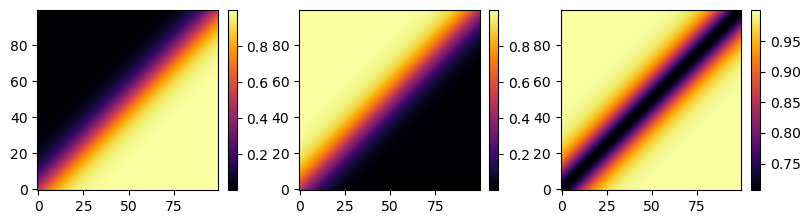

In [3]:
lamb = 7

sig_sum = np.exp(lamb*sigmas[0])+np.exp(lamb*sigmas[1])

samx = (np.exp(lamb*sigmas[0]))/sig_sum
samy = (np.exp(lamb*sigmas[1]))/sig_sum

resultant = (samx**2 + samy**2)**0.5

fig, ax = plt.subplots(1,3,figsize=(8,4))
fig.tight_layout()

im = ax[0].imshow(samx,cmap='inferno',origin='lower')
plt.colorbar(im,ax=ax[0],fraction=0.045)

im = ax[1].imshow(samy,cmap='inferno',origin='lower')
plt.colorbar(im,ax=ax[1],fraction=0.045)

im = ax[2].imshow(resultant,cmap='inferno',origin='lower')
plt.colorbar(im,ax=ax[2],fraction=0.045)

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Read data from a csv

z = resultant

z1 = samx
z2 = samy

x, y = sigmas[0],sigmas[1]

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]])

fig.add_trace(go.Surface(z=z1, x=x, y=y, opacity=0.6),#go.Surface(z=z2, x=x, y=y, opacity=0.6),
                1,1)
fig.add_trace(go.Surface(z=z, x=x, y=y, opacity=0.6),1,2)
# fig.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                   highlightcolor="limegreen", project_z=True))
fig.update_layout(title='SoftMax', autosize=False,
                  width=1000, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

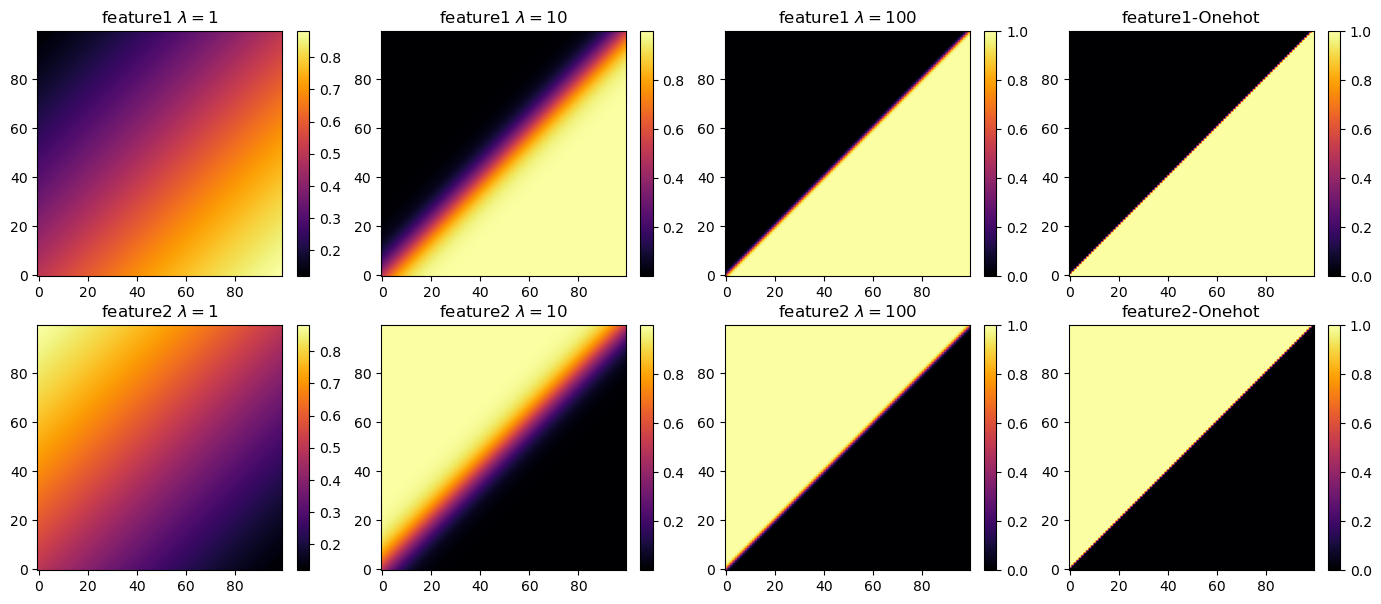

In [5]:
def softmax(sigmas, axis, lamb=1):
    # TODO: implement the softmax function. Axis should specify along which axis the sums should be computed.
    sig_sum = np.exp(lamb*sigmas[0])+np.exp(lamb*sigmas[1])
    if(axis==0):
        samx = (np.exp(lamb*sigmas[0]))/sig_sum
        return samx
    else:
        samy = (np.exp(lamb*sigmas[1]))/sig_sum
        return samy


    
# TODO: compute the argmax of each gridpoint in one-hot form
def to_onehot(f1):
    return [f1,(f1-1)*-1]

xy = np.stack((sigmas[0],sigmas[1]),axis=-1)
onehot_argmax = to_onehot(np.argmax(xy, axis=-1))

# TODO: make the plots as specified on the sheet (nicest is in a grid which you can get using plt.subplots)
def gen_plot(axs,arr,title):
    im = axs.imshow(arr,cmap='inferno',origin='lower')
    plt.colorbar(im,ax=axs,fraction=0.045)
    axs.set_title(title)


# plot the softmax
fig, axs = plt.subplots(2, 4, figsize=(17, 7))
for i,l in enumerate(lamb_array):
    gen_plot(axs[0,i],softmax(sigmas,axis=0,lamb=l),r"feature1 $\lambda=$"+str(l))
    gen_plot(axs[1,i],softmax(sigmas,axis=1,lamb=l),r"feature2 $\lambda=$"+str(l))

# plot the onehot argmax
gen_plot(axs[0,3],onehot_argmax[1],"feature1-Onehot")
gen_plot(axs[1,3],onehot_argmax[0],"feature2-Onehot")

### 3 Linear Regions of MLPs

(a)

In [10]:
# class Abs(nn.Module):
#     """Absolute value activation function. You can experiment with this instead of ReLU."""
#     def forward(self, x):
#         return x.abs()
    
    
# define NN architecture.
class MLPShallow(nn.Module): #Module: base classs (parent class)
    def __init__(self,n,p,k):
        """
        Attributes:
        n = no. of inputs
        p = no. of neurons hidden layers
        k = no. of neurons outputs
        """
        super(MLPShallow,self).__init__()
        # TODO: initialize Linear Layers and the activation as specified on the sheet
        self.hidden = nn.Linear(n,p,bias=True)
        self.relu = nn.ReLU()
        self.output = nn.Linear(p,k,bias=True)
        
    def forward(self, x):
        """
        Attributes:
        x = input matrix
        """
        # TODO: pass the input x through the layers and return the output
        a = self.relu(self.hidden(x))
        y = self.output(a)
        
        return y

(b)

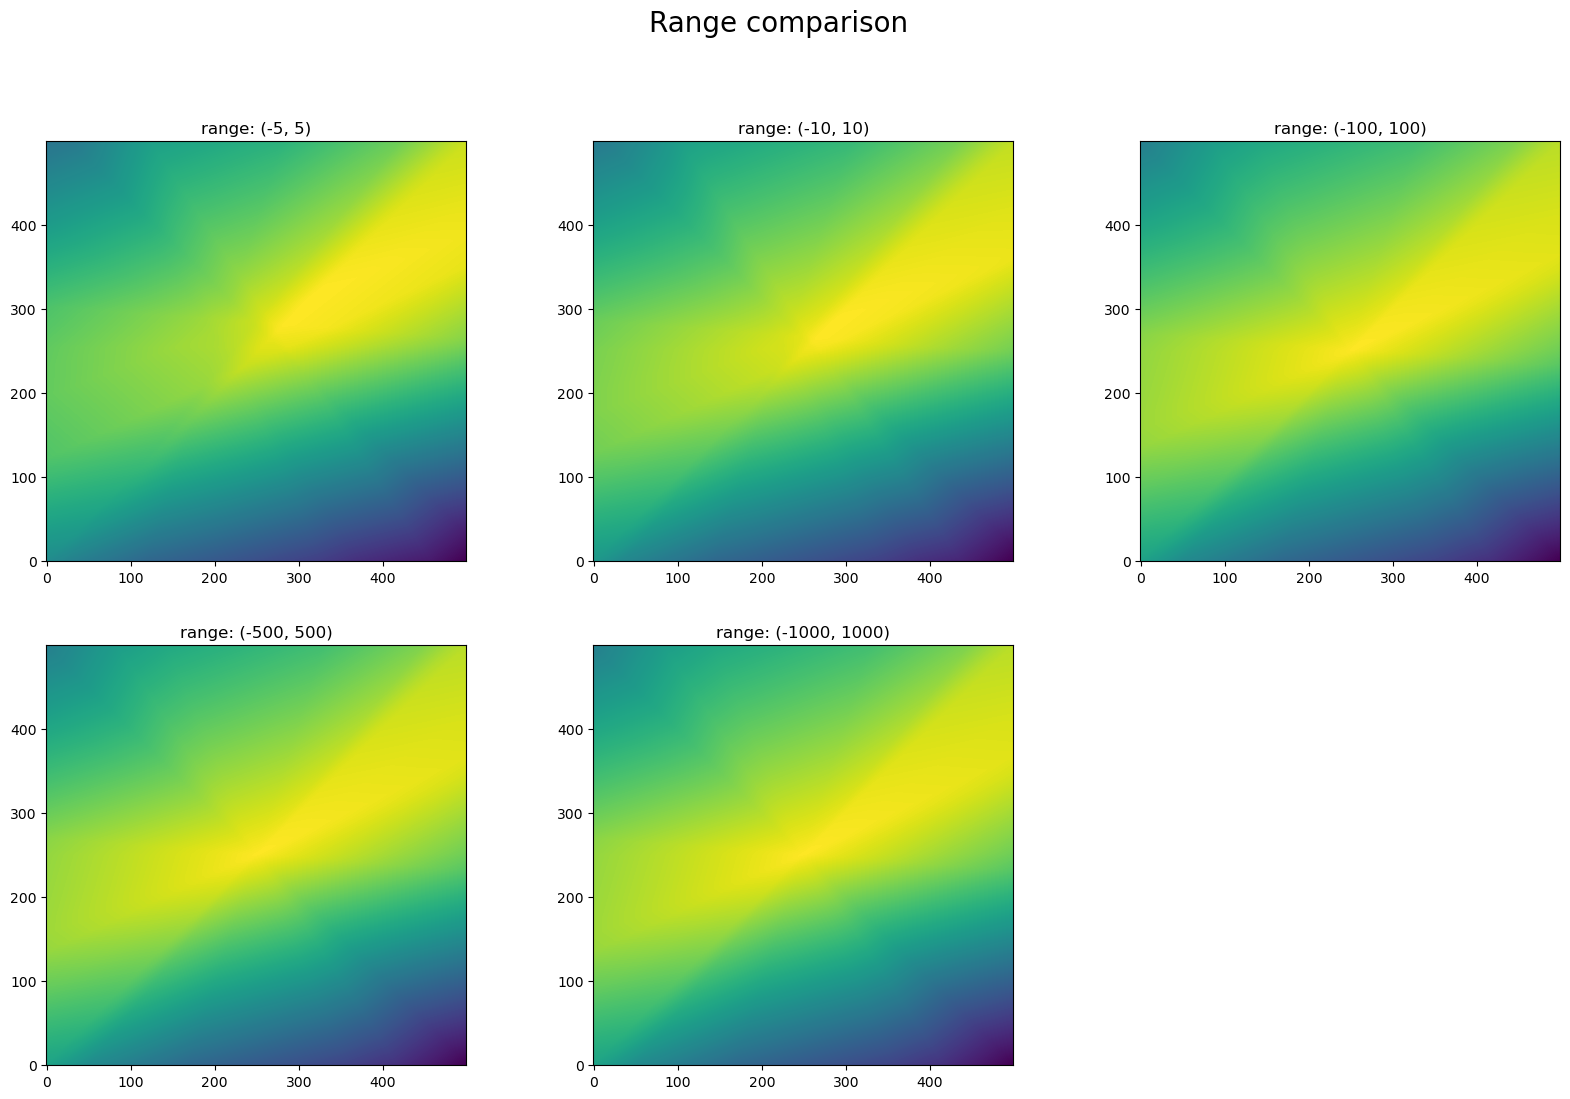

In [11]:
def visualize_model(model, res=500, bound=5):
    # TODO: implement a function that takes the model (the MLP), and builds a 
    #       grid of points in [-bound, bound] x [-bound, bound], passes them 
    #       through the model and returns the result in the shape of an image

    #grids of points
    x1 = np.linspace(-bound,bound,res)
    x2 = np.linspace(-bound,bound,res)
    x1v,x2v = np.meshgrid(x1,x2)                    

    # genrating the input torch.tensor 
    x = np.stack((x1v.ravel(),x2v.ravel()),axis=1)   
    x = torch.from_numpy(x).to(torch.float32)     

    # passing through model
    y = model(x)                                    
    
    return y.detach().numpy().reshape(res,res)      #reshaping the output vector into the shape of an image

# TODO: instantiate the model and make the visualizations as requested in the task
# NOTE: If you get a constant output, you got an unlucky initialization. Simply reinitialize the model.

model = MLPShallow(2,20,1)
bounds = [5,10,100,500,1000]
imgs = [visualize_model(model,res=500,bound=b) for b in bounds]

#Plotting the model outputs for diffferent ranges
plt.figure(figsize=(20,12))
plt.suptitle('Range comparison', fontsize=20, y=0.99)
plt.tight_layout()
#setting no. of rows and columns for subplot
ncols = 3
nrows = len(imgs) // ncols + (len(imgs) % ncols > 0) # calculating number of rows

for n,im in enumerate(imgs):
    #adding subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)

    ax.imshow(im,origin='lower')
    ax.set_title(f'range: {-bounds[n],bounds[n]}')
    ax.set_aspect('equal')

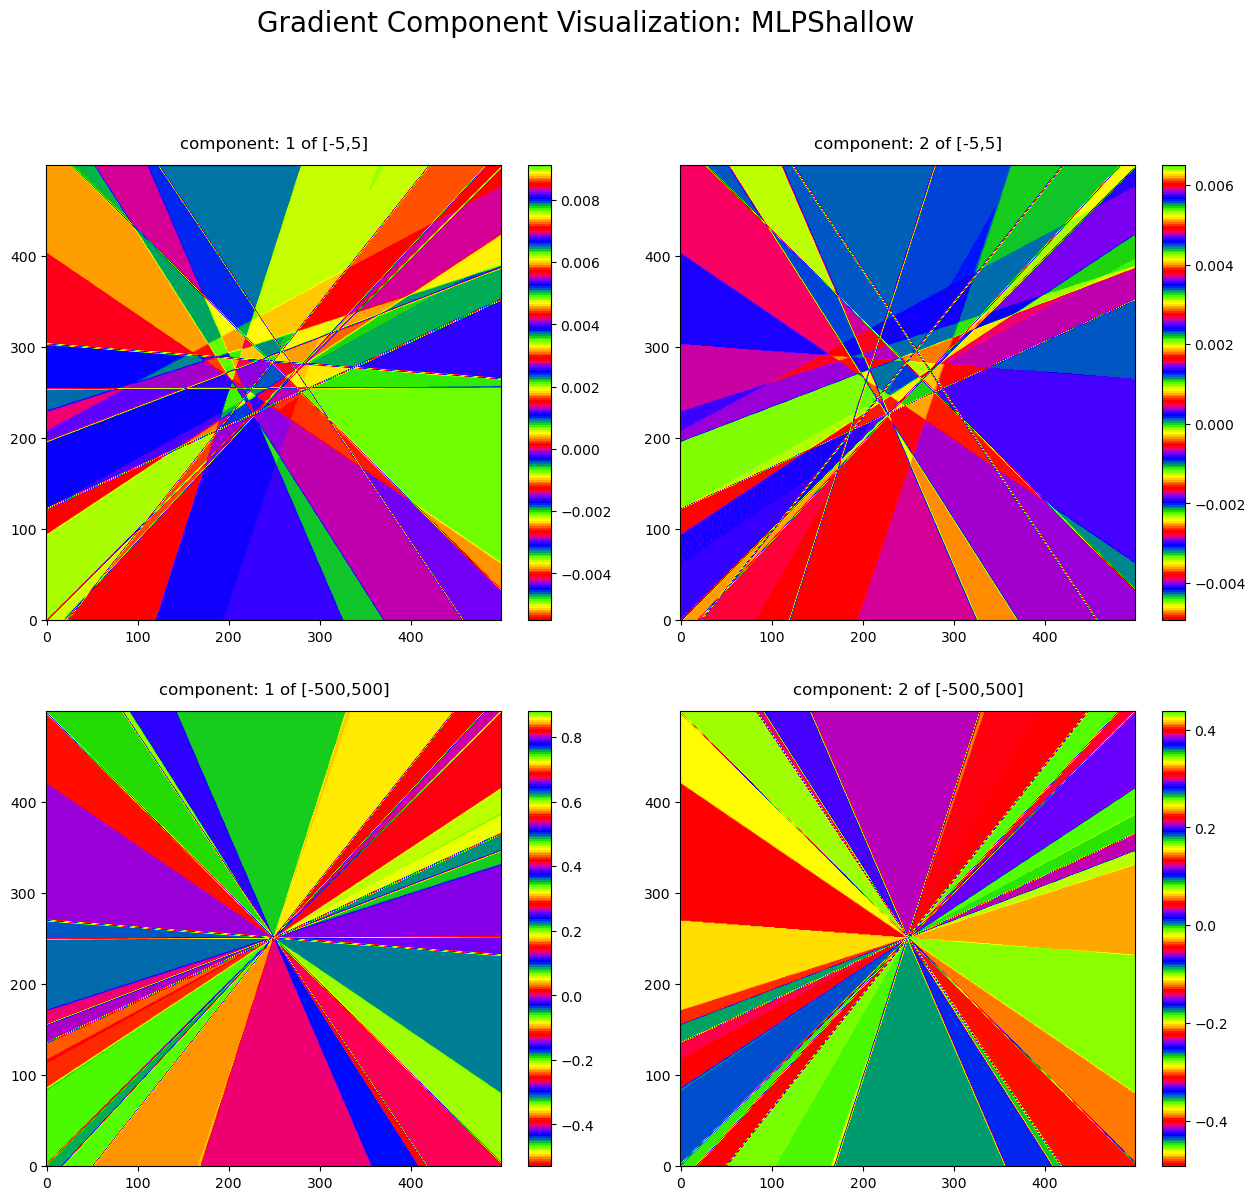

In [12]:
# TODO: compute the spatial gradient of the network outputs (as an image) from (b)
#       using np.gradient, and visualize using matplotlib's prism colormap

c1, c2 = np.gradient(imgs[0]) #for range (-5,5)
c3, c4 = np.gradient(imgs[3]) #for range (-500,500)

# plotting the model outputs for different ranges

fig = plt.figure(figsize=(15,13))
plt.suptitle('Gradient Component Visualization: MLPShallow', fontsize=20, y=1)
plt.tight_layout()

#setting no. of rows and columns for subplot
ncols = 2
nrows = 2

c = [c1,c2,c3,c4]
label = ['component: 1 of [-5,5]','component: 2 of [-5,5]','component: 1 of [-500,500]','component: 2 of [-500,500]']

for n,(ci,li) in enumerate(zip(c,label)):
    #adding subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)

    cim = ax.imshow(ci,origin='lower',cmap='prism')
    ax.set_title(li, y=1.02)
    ax.set_aspect('equal')
    fig.colorbar(cim, ax=ax, fraction=0.046)

(d)

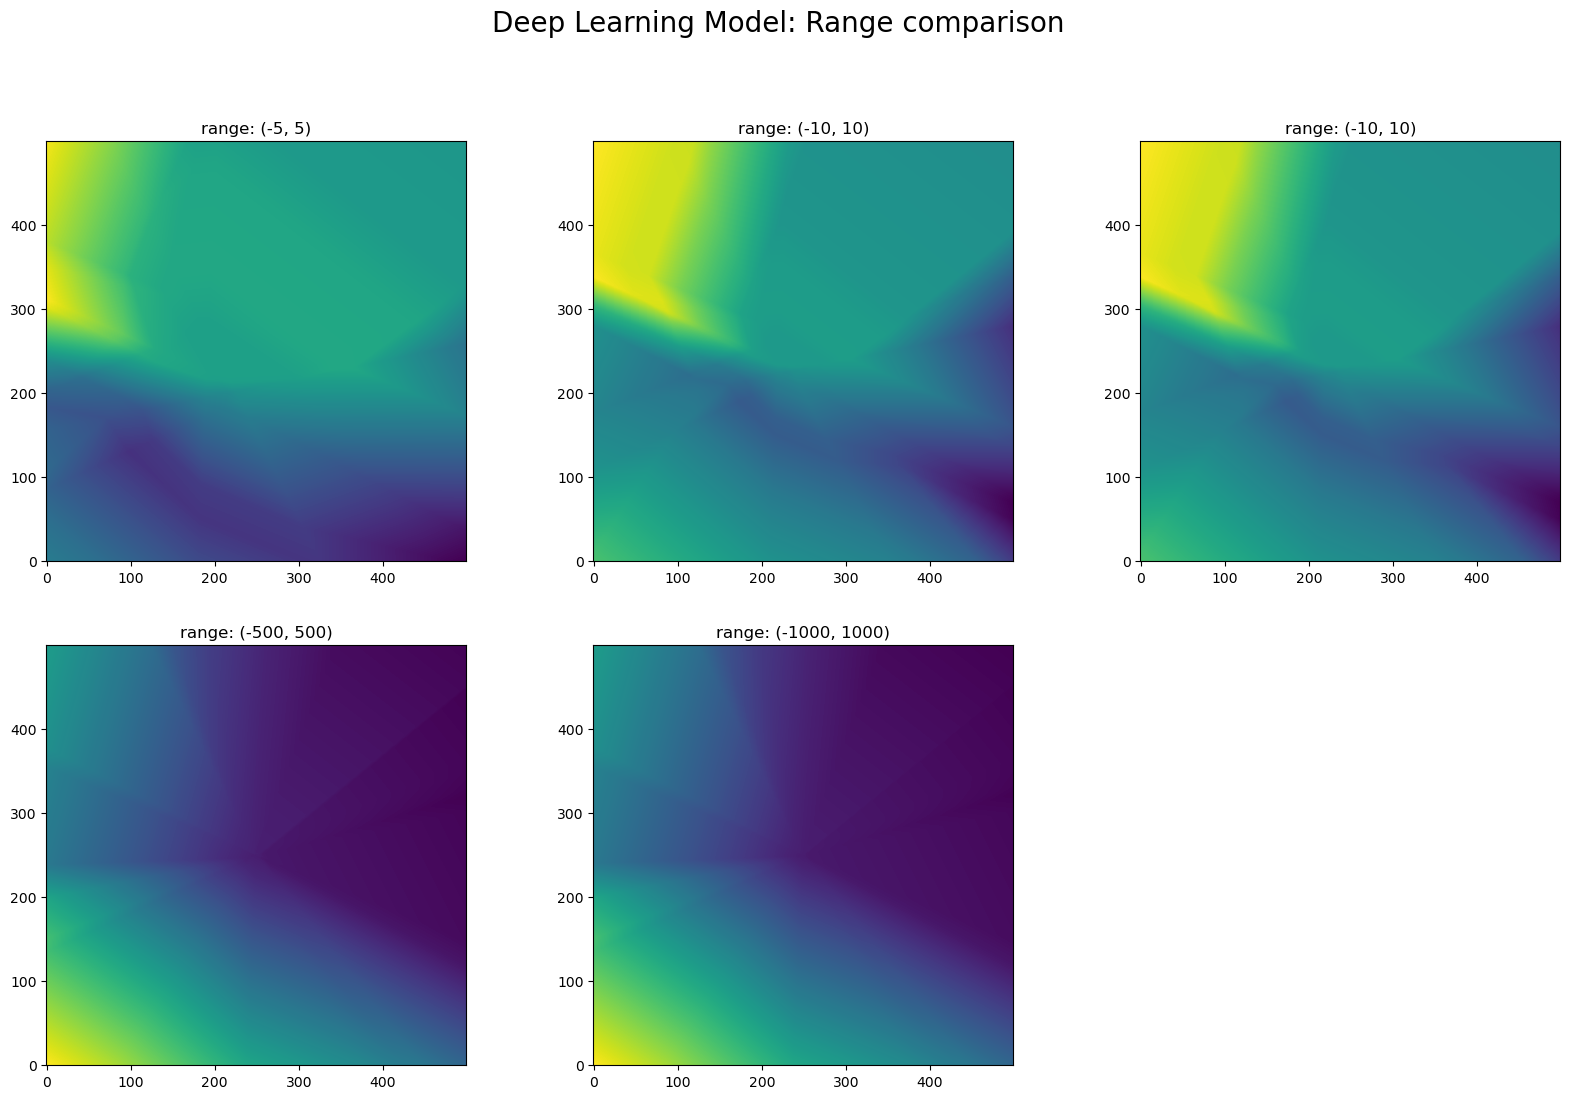

In [15]:
# define NN architecture.
class MLPDeep(nn.Module):
    def __init__(self,n=2,p=5,k=1):
        """
        Attributes:
        n : no. of inputs (dimensions)
        p : no. of neurons in hidden layers
        k : no. of nuerons in output layer
        """
        super(MLPDeep,self).__init__()
        # TODO: initialize Linear Layers and the activation as specified on the sheet
        self.multi_hidden = nn.Sequential(
                            nn.Linear(n,p),
                            nn.ReLU(),
                            nn.Linear(p,p),
                            nn.ReLU(),
                            nn.Linear(p,p),
                            nn.ReLU(),
                            nn.Linear(p,p),
                            nn.ReLU(),
                            nn.Linear(p,k))
        
    def forward(self, x):
        # TODO: pass the input x through the layers and return the output
        y = self.multi_hidden(x)
        return y

# TODO: repeat the visualizations from above
model_deep = MLPDeep(2,5,1)
bounds = [5,10,10,500,1000]
img = [visualize_model(model_deep,res=500, bound=bound) for bound in bounds]

# plotting the model outputs for different ranges

plt.figure(figsize=(20,12))
plt.suptitle('Deep Learning Model: Range comparison', fontsize=20, y=0.99)
plt.tight_layout()
#setting no. of rows and columns for subplot
ncols = 3
nrows = len(img) // ncols + (len(img) % ncols > 0) # calculating number of rows

for n,im in enumerate(img):
    #adding subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)

    ax.imshow(im,origin='lower')
    ax.set_title(f'range: {-bounds[n],bounds[n]}')
    ax.set_aspect('equal')
